# Diagrams

This notebook generates all the diagrams for the paper.

In [1]:
from os.path import exists
from copy import deepcopy
import numpy
from geopandas import GeoDataFrame, GeoSeries, read_file

from sensor_placement import *
from sensor_placement.data import *
from sensor_placement.matplotlib import *

import shapely
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint, shape
from shapely.ops import cascaded_union, nearest_points, voronoi_diagram
from shapely.affinity import translate

import logging
logging.basicConfig(level=logging.INFO)

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm, ListedColormap, to_rgba
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle
from matplotlib.collections import PolyCollection
from matplotlib.ticker import StrMethodFormatter

In [2]:
plt.style.use(['default', 'print.mplstyle'])
rng = numpy.random.default_rng()

## Natural nearest-neighbour interpolation

In [3]:
boundary = Polygon([Point(0.0, 0.0),
                    Point(0.0, 1.0),
                    Point(1.0, 1.0),
                    Point(1.0, 0.0)])

In [4]:
complicated = [Point((rng.random() * 0.90) + 0.05,
                     (rng.random() * 0.90) + 0.05) for _ in range(10)]
df_complicated = GeoDataFrame({'geometry': complicated})
df_complicated['rainfall'] = [rng.random()* 20 for _ in range(len(df_complicated))]

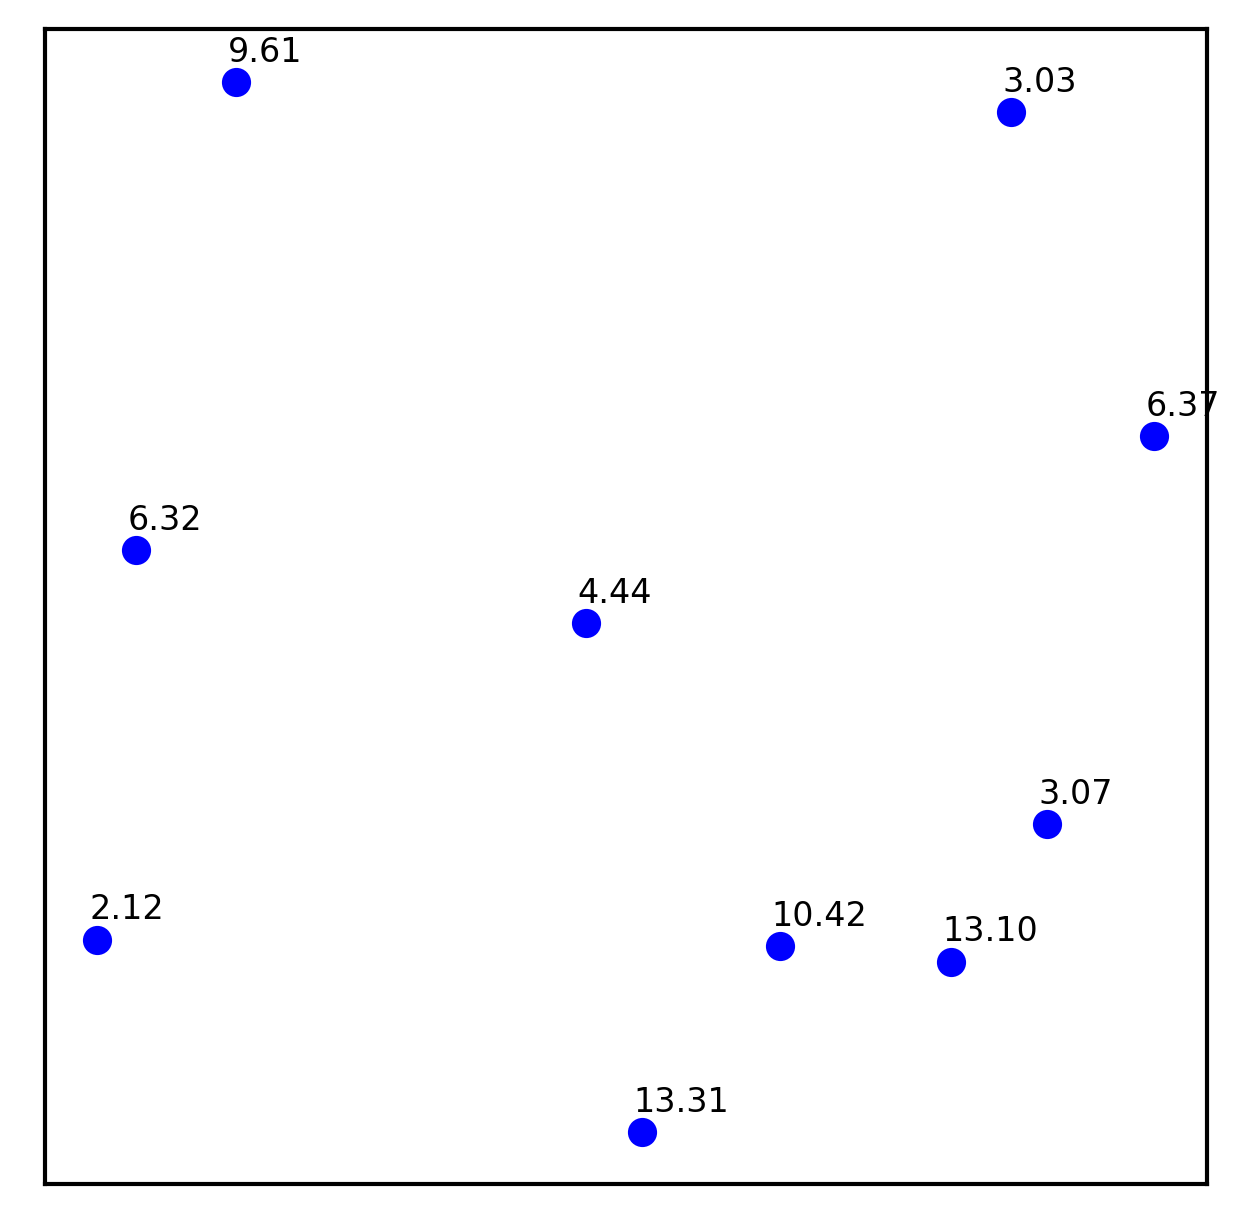

In [5]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

for i in range(len(df_complicated)):
    v = df_complicated.loc[i]
    [(x, y)] = list(v.geometry.coords)
    plt.scatter([x], [y], c='b')

    rainfall = v.rainfall
    ax.annotate(f'{rainfall:.02f}', (x, y),
                xytext=(-2, 5), textcoords='offset points')
    
plt.savefig('diagrams/nnni-samples.png')
_ = plt.show()

/home/sd80/programming/sensor-placement/venv3/lib/python3.7/site-packages/pandas/core/construction.py:737: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  subarr = construct_1d_object_array_from_listlike(arr)
/home/sd80/programming/sensor-placement/venv3/lib/python3.7/site-packages/pandas/core/construction.py:737: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  subarr = construct_1d_object_array_from_listlike(arr)
/home/sd80/programming/sensor-placement/venv3/lib/python3.7/site-packages/pandas/core/construction.py:737: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  subarr = construct_1d_object_array_from_listlike(arr)
/home/sd80/programming/sensor-placement/venv3/lib/python3.7/site

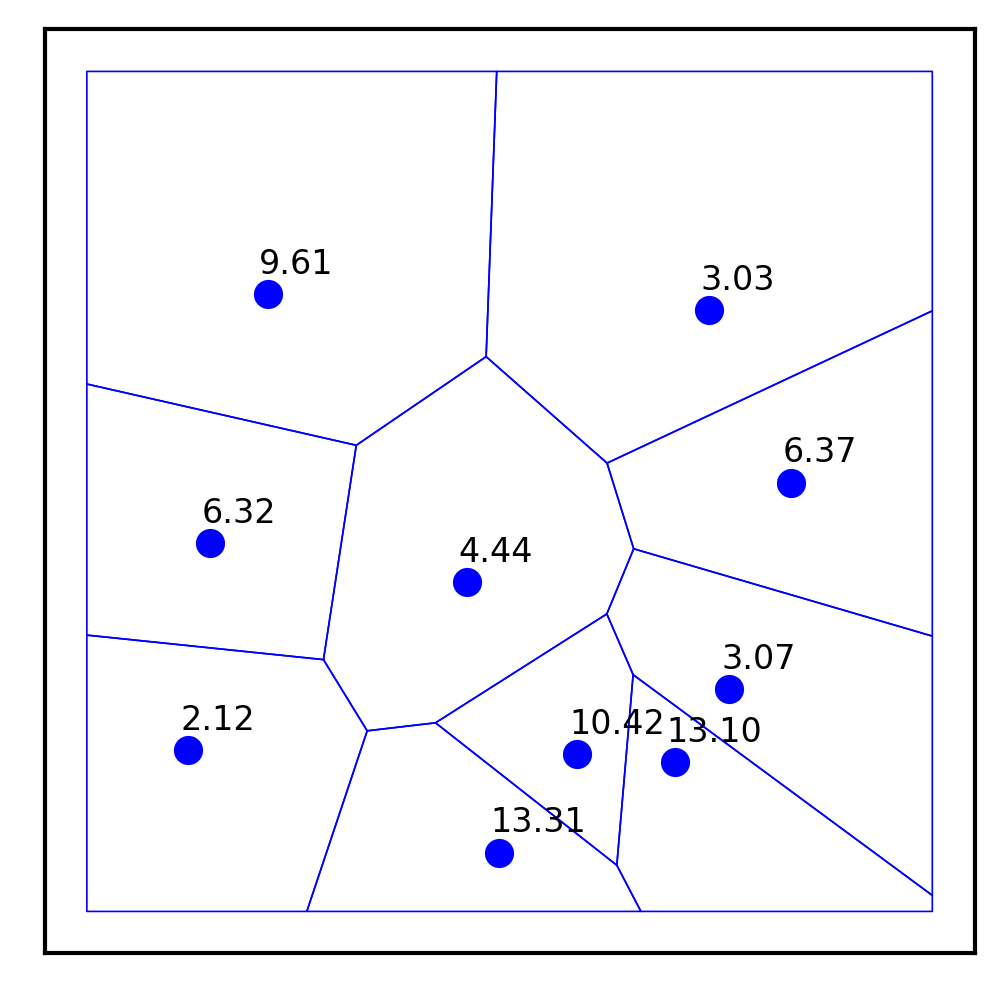

In [6]:
voronoi_cells = voronoi_diagram(MultiPoint(df_complicated.geometry), boundary)
df_voronoi = GeoDataFrame(columns=['centre', 'geometry'])
for p in df_complicated.geometry:
    g = [voronoi_cells.geoms[i] for i in range(len(voronoi_cells.geoms)) if p.within(voronoi_cells.geoms[i])][0]
    df_voronoi.loc[len(df_voronoi.index)] = {'centre': p,
                                             'geometry': g.intersection(boundary)}
    
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

for i in range(len(df_voronoi)):
    v = df_voronoi.iloc[i]
    [(x, y)] = list(v.centre.coords)
    plt.scatter([x], [y], c='b')

    xs, ys = v.geometry.exterior.xy
    ax.plot(xs, ys, 'b')

    rainfall = df_complicated[df_complicated.geometry == v.centre].rainfall.iloc[0]
    ax.annotate(f'{rainfall:.02f}', (x, y),
                xytext=(-2, 5), textcoords='offset points')
    
plt.savefig('diagrams/nnni-voronoi.png')
_ = plt.show()

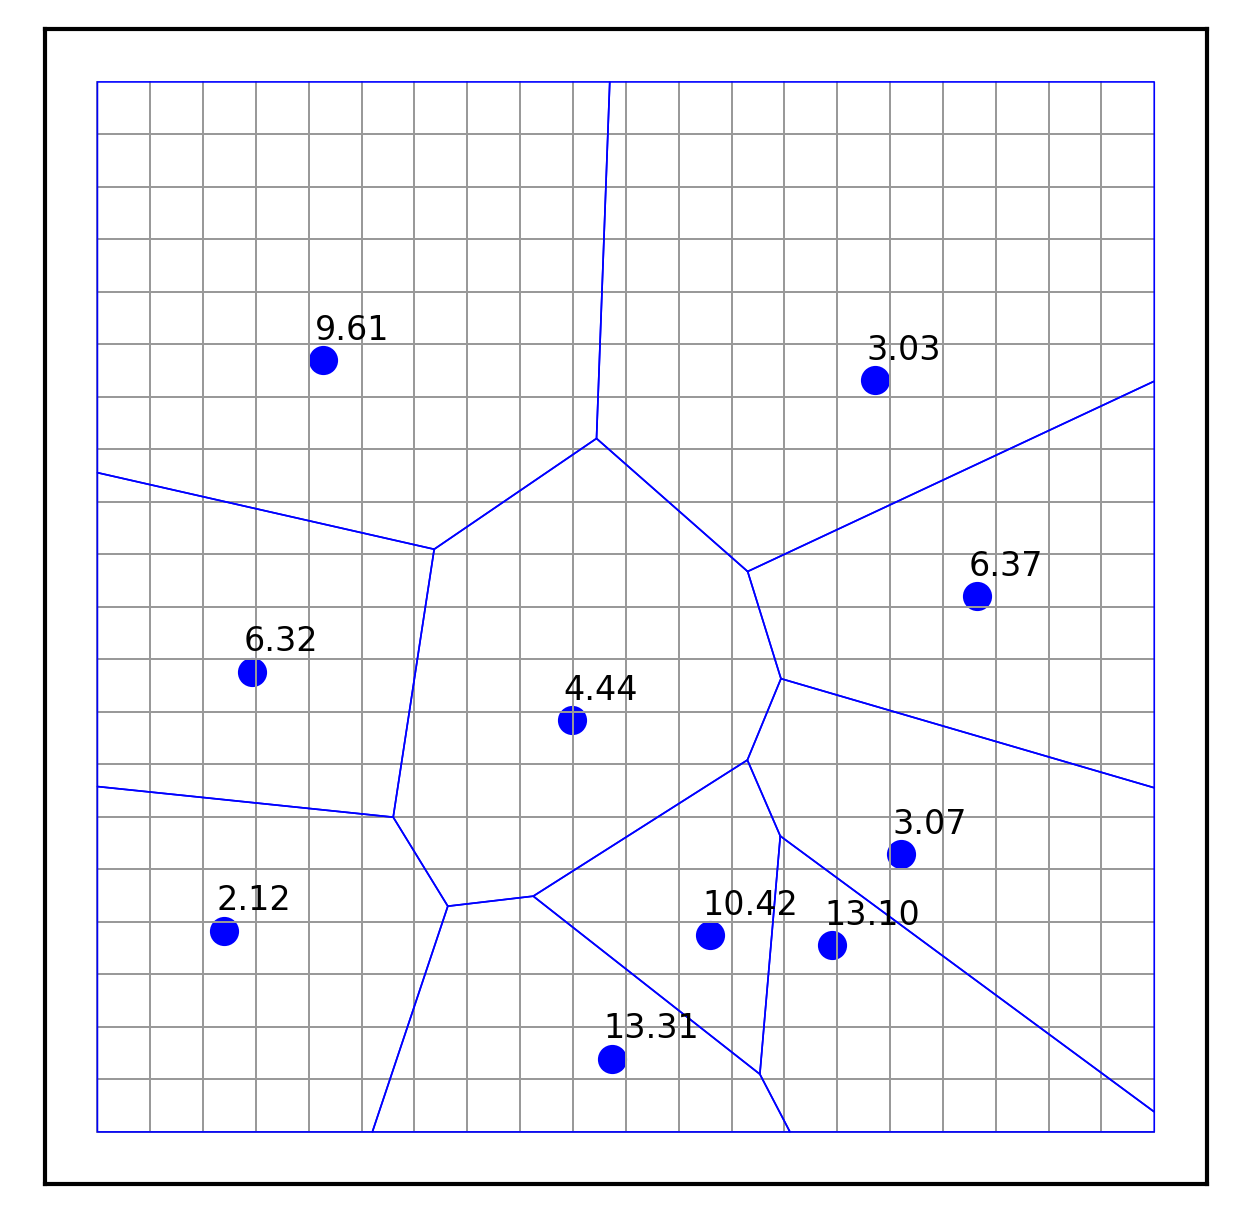

In [7]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

for x in range(20):
    for y in range(20):
        ax.plot([x / 20, x / 20], [0.0, 1.0], '0.6')
        ax.plot([0.0, 1.0], [y / 20, y / 20], '0.6')
        
for i in range(len(df_voronoi)):
    v = df_voronoi.loc[i]
    [(x, y)] = list(v.centre.coords)
    plt.scatter([x], [y], c='b')

    xs, ys = v.geometry.exterior.xy
    ax.plot(xs, ys, 'b')

    rainfall = df_complicated[df_complicated.geometry == v.centre].rainfall.iloc[0]
    ax.annotate(f'{rainfall:.02f}', (x, y),
                xytext=(-2, 5), textcoords='offset points')
    
plt.savefig('diagrams/nnni-interpolation.png')
_ = plt.show()

In [8]:
df_synthetic = df_complicated.copy()
synthetic = Point(0.65, 0.3)
df_synthetic.loc[len(df_synthetic.index)] = {'geometry': synthetic}

voronoi_cells = voronoi_diagram(MultiPoint(df_synthetic.geometry), boundary)
df_synthetic_voronoi = GeoDataFrame(columns=['centre', 'geometry'])
for p in df_synthetic.geometry:
    g = [voronoi_cells.geoms[i] for i in range(len(voronoi_cells.geoms)) if p.within(voronoi_cells.geoms[i])][0]
    df_synthetic_voronoi.loc[len(df_synthetic_voronoi.index)] = {'centre': p,
                                                                 'geometry': g.intersection(boundary)}

# find the cell with the synthetic point
synthetic_cell = df_synthetic_voronoi[df_synthetic_voronoi['centre'] == synthetic].index[0]

/home/sd80/programming/sensor-placement/venv3/lib/python3.7/site-packages/pandas/core/construction.py:737: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  subarr = construct_1d_object_array_from_listlike(arr)
/home/sd80/programming/sensor-placement/venv3/lib/python3.7/site-packages/pandas/core/construction.py:737: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  subarr = construct_1d_object_array_from_listlike(arr)
/home/sd80/programming/sensor-placement/venv3/lib/python3.7/site-packages/pandas/core/construction.py:737: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  subarr = construct_1d_object_array_from_listlike(arr)
/home/sd80/programming/sensor-placement/venv3/lib/python3.7/site

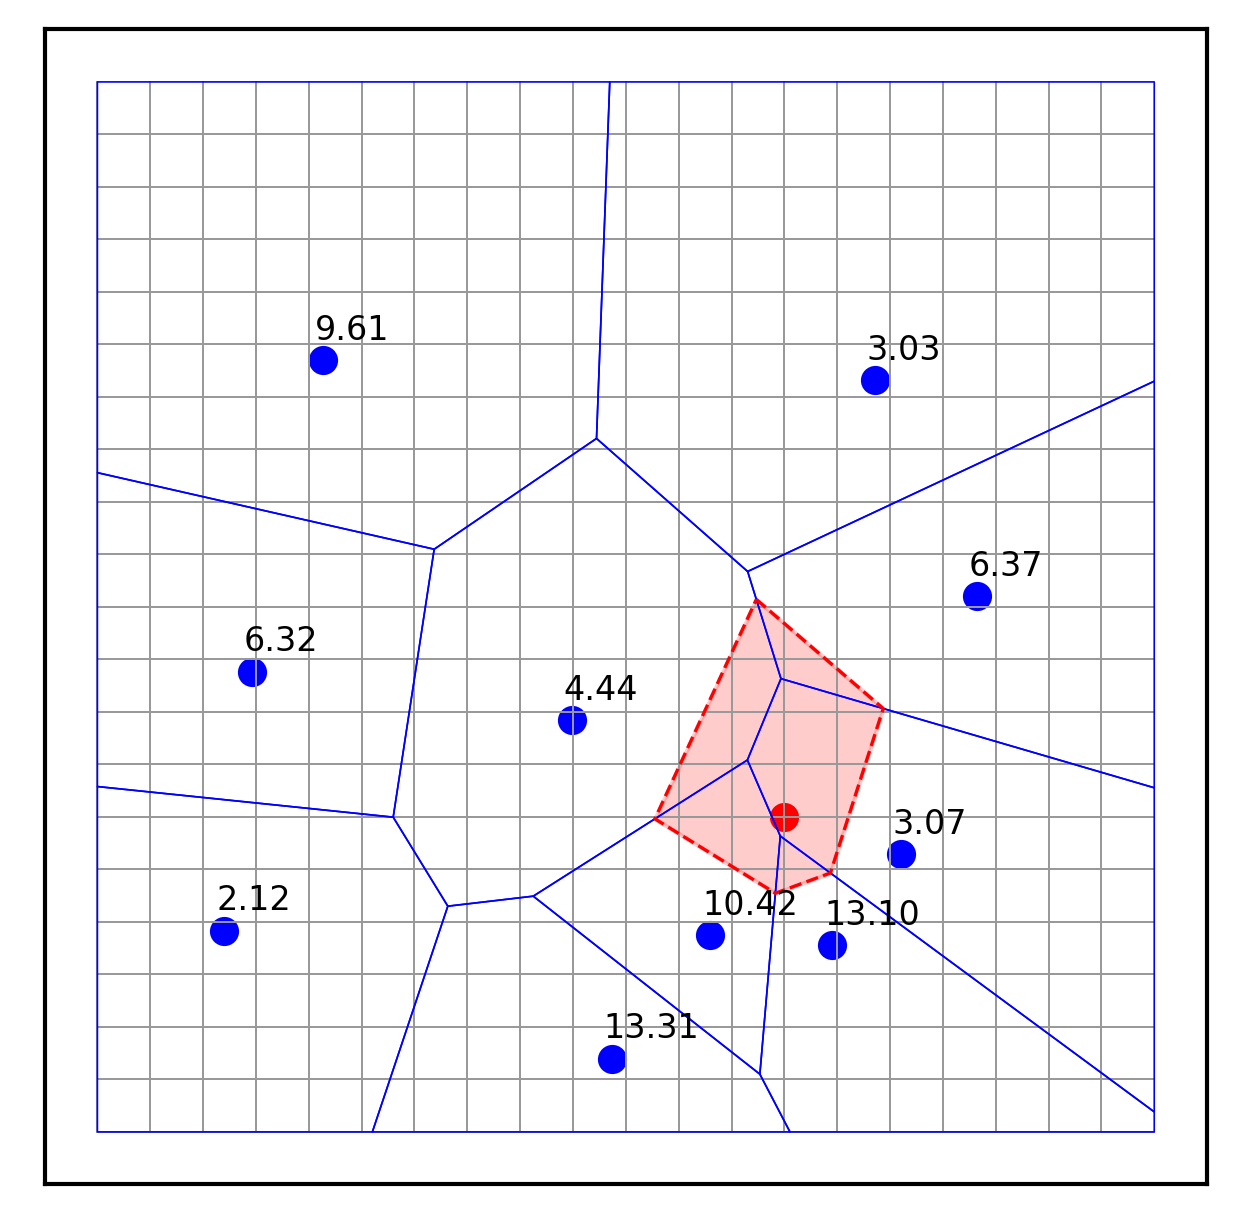

In [9]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

# draw interpolation grid
for x in range(20):
    for y in range(20):
        ax.plot([x / 20, x / 20], [0.0, 1.0], '0.6')
        ax.plot([0.0, 1.0], [y / 20, y / 20], '0.6')

# draw samples and Voronoi cells
for i in range(len(df_voronoi)):
    v = df_voronoi.loc[i]
    [(x, y)] = list(v['centre'].coords)
    plt.scatter([x], [y], c='b')

    xs, ys = v.geometry.exterior.xy
    ax.plot(xs, ys, 'b')

    rainfall = df_complicated[df_complicated.geometry == v.centre].rainfall.iloc[0]
    ax.annotate(f'{rainfall:.02f}', (x, y),
                xytext=(-2, 5), textcoords='offset points')

# draw the synthetic cell
v = df_synthetic_voronoi.loc[synthetic_cell]
[(x, y)] = list(v['centre'].coords)
plt.scatter([x], [y], c='r')
xs, ys = v.geometry.exterior.xy
ax.plot(xs, ys, 'r', linestyle='--', linewidth=0.8)

# shade the synthetic cell
vertices = [list(v.geometry.exterior.coords)]
poly = PolyCollection(vertices, color='r')
poly.set_alpha(0.2)
ax.add_collection(poly)

plt.savefig('diagrams/nnni-synthetic-voronoi.png')
_ = plt.show()

## General approach

In [10]:
points = [Point(0.25, 0.25), Point(0.75, 0.4), Point(0.4, 0.85)]
df_samples = GeoDataFrame(points, columns=['geometry'])

In [11]:
pointsPer = 100

dx = 1 / (pointsPer + 1)
xs = [ (x + 1) * dx for x in range(pointsPer)]
ys = [ (pointsPer - y) * dx for y in range(pointsPer)]

In [12]:
bxs, bys = boundary.exterior.coords.xy

/home/sd80/programming/sensor-placement/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


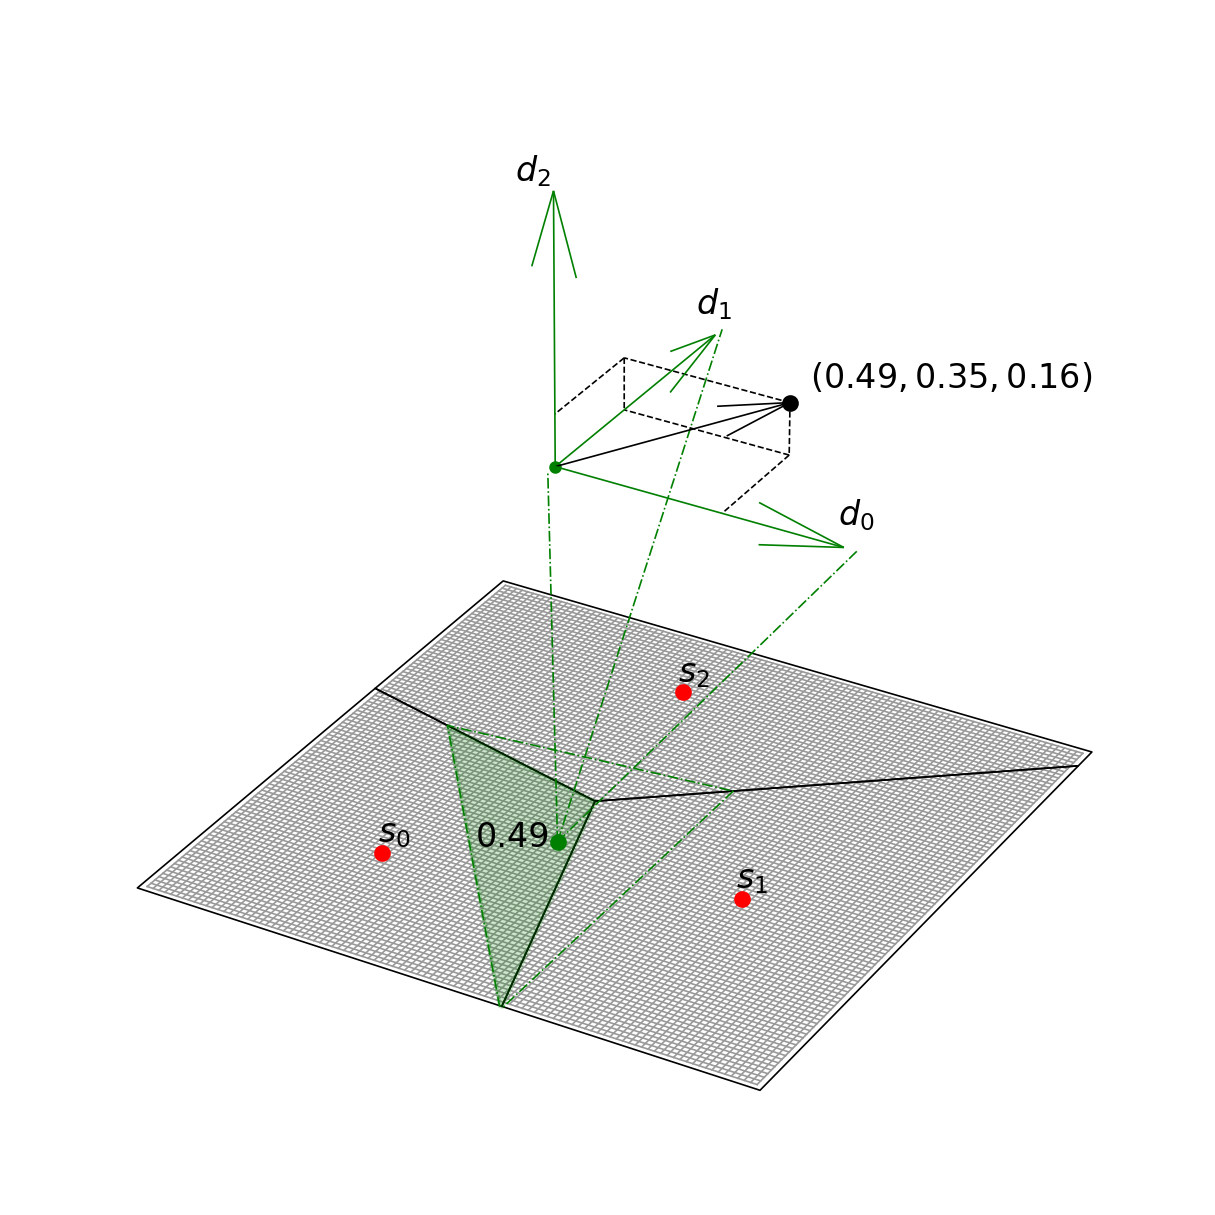

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d', xticks=[], yticks=[], zticks=[])
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_zlim([0.0, 0.8])
ax.set_frame_on(False)
ax.axis('off')
db = 0.02

# draw interpolation grid lines
for y in ys:
    ax.plot(xs, [y] * len(xs), color='0.6')
for x in ys:
    ax.plot([x] * len(xs), ys, color='0.6')
    
# draw sample points
for i in df_samples.geometry.index:
    pt = df_samples.geometry.loc[i]
    x, y = pt.coords.xy
    ax.plot(x[0], y[0], marker='o', markersize=3, color='r')
    ax.text(x[0] - db, y[0] + db, 0.0, f'$s_{i}$')

# Voronoi cells
real_points = list(df_samples.geometry)
raw_voronoi_cells = voronoi_diagram(MultiPoint(real_points), boundary)

# put cells into sample point order
voronoi_cells = []
for i in df_samples.index:
    pt = df_samples.geometry.loc[i]
    c = [c for c in raw_voronoi_cells if c.contains(pt)][0]
    voronoi_cells.append(c.intersection(boundary))
    
# draw cells
for c in voronoi_cells:
    x, y = c.exterior.xy
    ax.plot(x, y, color='k')

# interpolation point
ix, iy = 0.45, 0.40

# synthetic cell
synthetic_points = real_points + [Point(ix, iy)]
synthetic_voronoi_cells =  voronoi_diagram(MultiPoint(synthetic_points), boundary)
synthetic_c = [synthetic_voronoi_cells.geoms[i] for i in range(len(synthetic_voronoi_cells.geoms)) if Point(ix, iy).within(synthetic_voronoi_cells.geoms[i])][0]

# draw synthetic cell
x, y = synthetic_c.intersection(boundary).exterior.xy
ax.plot(x, y, color='g', linestyle='-.')

# weights
w = []
synthetic_area = synthetic_c.area
for c in voronoi_cells:
    area = c.intersection(synthetic_c).area
    w.append(area / synthetic_area)

# chosen overlap to highlight
ci = 0
chosen = voronoi_cells[ci].intersection(synthetic_c)
vertices = [list(chosen.exterior.coords)]
poly = PolyCollection(vertices, color='g')
poly.set_alpha(0.2)
ax.add_collection3d(poly)
    
# annotate overlap with its weight
x, y = chosen.centroid.coords.xy
ax.text(x[0] - 2 * db, y[0] - 2 * db, 0.0, '{dw:.2f}'.format(dw=w[ci]))

# draw and label vector space axes
iz = 0.65
dx = 0.45
ax.plot(ix, iy, iz, marker='o', color='g', markersize=2)
ax.quiver(ix, iy, iz, dx, 0.0, 0.0, color='g')
ax.quiver(ix, iy, iz, 0.0, dx, 0.0, color='g')
ax.quiver(ix, iy, iz, 0.0, 0.0, dx, color='g')
ax.text(ix + dx - db, iy + db, iz + db, '$d_0$')
ax.text(ix - db, iy + dx - db, iz + 2 * db, '$d_1$')
ax.text(ix - 3 * db, iy, iz + dx, '$d_2$')

# explode interpolation point to axes
ax.plot(ix, iy, 0.0, marker='o', markersize=3, color='g')
ax.plot([ix, ix], [iy, iy - db], [0.0, iz], color='g', linestyle='-.')
ax.plot([ix, ix + dx + db], [iy, iy], [0.0, iz], color='g', linestyle='-.')
ax.plot([ix, ix], [iy, iy + dx + db], [0.0, iz], color='g', linestyle='-.')

# draw weight covector
dw = 1.2 * dx
wx, wy, wz = ix + w[0] * dw, iy + w[1] * dw, iz + w[2] * dw
ax.quiver(ix, iy, iz, w[0] * dw, w[1] * dw, w[2] * dw, color='k')
ax.plot(wx, wy, wz, marker='o', markersize=3, color='k')
ax.text(wx + db, wy + db, wz + db,
       '$({wx:.2f}, {wy:.2f}, {wz:.2f})$'.format(wx=w[0], wy = w[1], wz=w[2]))

# draw lines from covector to axes
ax.plot([wx, ix], [wy, wy], [wz, wz], color='k', linestyle='--')
ax.plot([ix, ix], [wy, iy], [wz, wz], color='k', linestyle='--')
ax.plot([ix, ix], [wy, wy], [wz, iz], color='k', linestyle='--')
ax.plot([wx, wx], [wy, wy], [wz, iz], color='k', linestyle='--')
ax.plot([wx, wx], [wy, iy], [iz, iz], color='k', linestyle='--')
ax.plot([wx, ix], [wy, wy], [iz, iz], color='k', linestyle='--')
    
plt.savefig('diagrams/interpolation-vector-space.png')
_ = plt.show()

## Projection into 2d

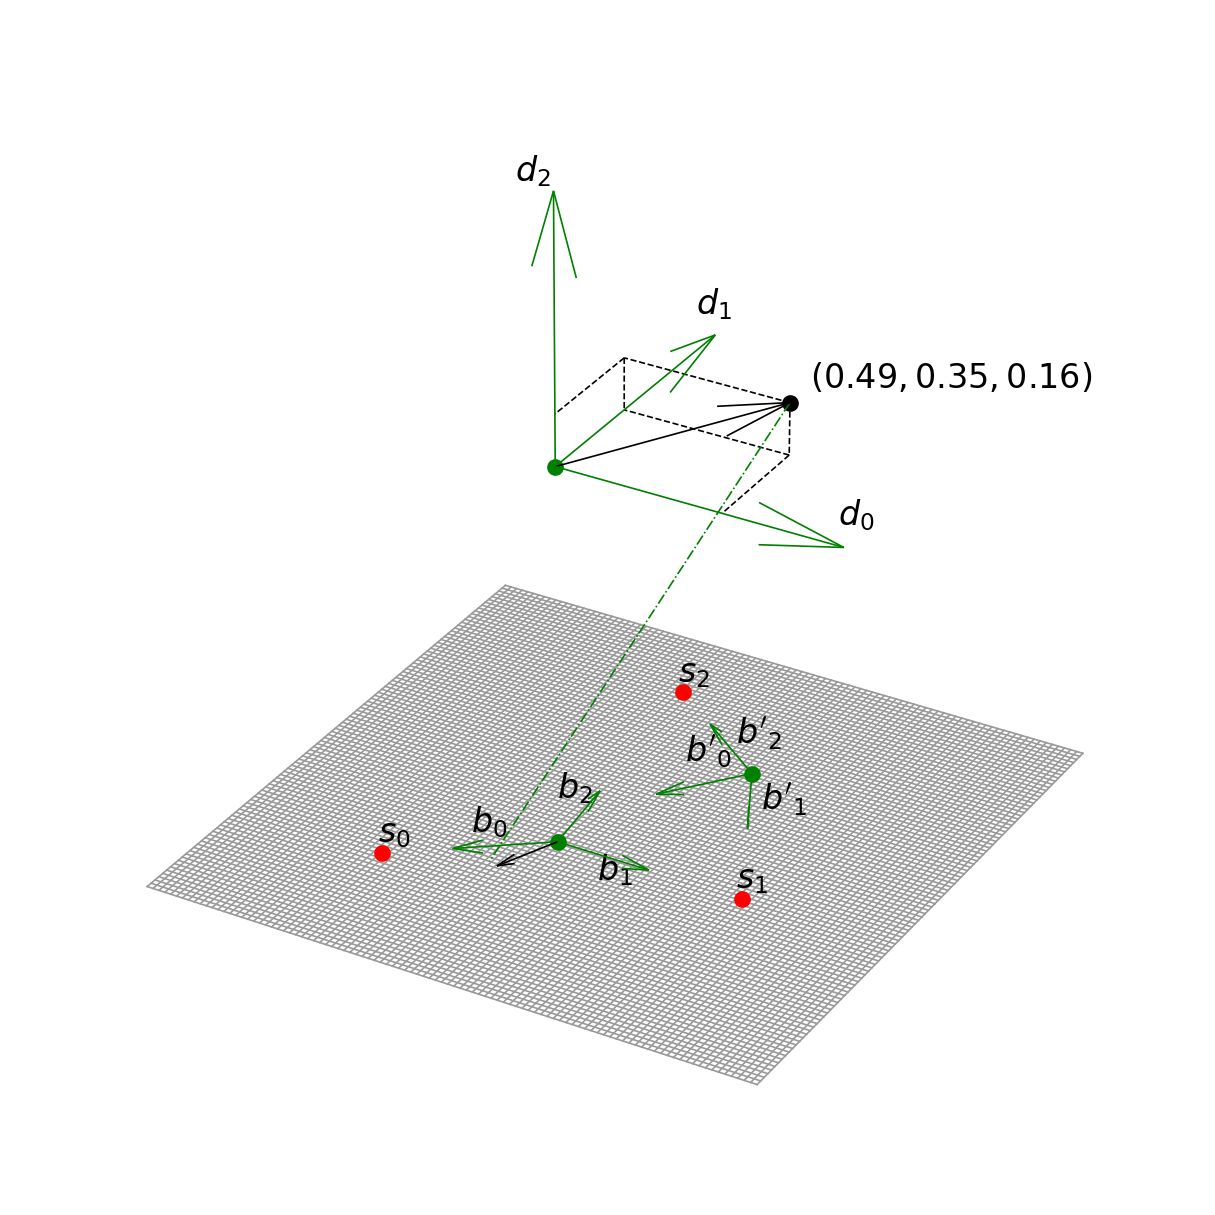

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d', xticks=[], yticks=[], zticks=[])
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_zlim([0.0, 0.8])
ax.set_frame_on(False)
ax.axis('off')

# draw interpolation grid lines
for y in ys:
    ax.plot(xs, [y] * len(xs), color='0.6')
for x in ys:
    ax.plot([x] * len(xs), ys, color='0.6')
    
# draw sample points
for i in df_samples.geometry.index:
    pt = df_samples.geometry.loc[i]
    x, y = pt.coords.xy
    ax.plot(x[0], y[0], marker='o', markersize=3, color='r')
    ax.text(x[0] - db, y[0] + db, 0.0, f'$s_{i}$')

# draw and label vector space axes
ax.plot(ix, iy, iz, marker='o', markersize=3, color='g')
ax.quiver(ix, iy, iz, dx, 0.0, 0.0, color='g')
ax.quiver(ix, iy, iz, 0.0, dx, 0.0, color='g')
ax.quiver(ix, iy, iz, 0.0, 0.0, dx, color='g')
ax.text(ix + dx - db, iy + db, iz + db, '$d_0$')
ax.text(ix - db, iy + dx - db, iz + 2 * db, '$d_1$')
ax.text(ix - 3 * db, iy, iz + dx, '$d_2$')

# draw weight covector
ax.quiver(ix, iy, iz, w[0] * dw, w[1] * dw, w[2] * dw, color='k')
ax.plot(wx, wy, wz, marker='o', markersize=3, color='k')
ax.text(wx + db, wy + db, wz + db,
       '$({wx:.2f}, {wy:.2f}, {wz:.2f})$'.format(wx=w[0], wy = w[1], wz=w[2]))

# draw lines from covector to axes
ax.plot([wx, ix], [wy, wy], [wz, wz], color='k', linestyle='--')
ax.plot([ix, ix], [wy, iy], [wz, wz], color='k', linestyle='--')
ax.plot([ix, ix], [wy, wy], [wz, iz], color='k', linestyle='--')
ax.plot([wx, wx], [wy, wy], [wz, iz], color='k', linestyle='--')
ax.plot([wx, wx], [wy, iy], [iz, iz], color='k', linestyle='--')
ax.plot([wx, ix], [wy, wy], [iz, iz], color='k', linestyle='--')

# compute basis vectors
b = []
for i in df_samples.geometry.index:
    pt = df_samples.geometry.loc[i]
    bx, by = makeVector(Point(ix, iy), pt, dx / 3)
    b.append((bx, by))
    
# draw sample point and projection basis vectors
ax.plot(ix, iy, 0.0, marker='o', markersize=3, color='g')
for (x, y) in b:
    ax.quiver(ix, iy, 0.0, x, y, 0.0, color='g')
ax.text(ix - 6 * db, iy - 2 * db, 0.0, '$b_0$')
ax.text(ix + 5 * db, iy - 3 * db, 0.0, '$b_1$')
ax.text(ix - 3 * db, iy + 5 * db, 0.0, '$b_2$')

# resolve weight covector onto projection basis
rx, ry = 0, 0
for i in df_samples.geometry.index:
    pt = df_samples.geometry.loc[i]
    bx, by = makeVector(Point(ix, iy), pt, (dx / 3) * w[i] * 5)
    rx += bx
    ry += by
ax.quiver(ix, iy, 0.0, rx, ry, 0.0, color='k')

# explode interpolation vector to projection space
ax.plot([ix + w[0] * dw, ix + rx], [iy + w[1] * dw, iy + ry - db], [iz + w[2] * dw, 0.0 + db], color='g', linestyle='-.')

# draw an alternative sample point and projection basis vectors
ox, oy = 0.6, 0.7
ob = []
for i in df_samples.geometry.index:
    pt = df_samples.geometry.loc[i]
    bx, by = makeVector(Point(ox, oy), pt, dx / 3)
    ob.append((bx, by))
ax.plot(ox, oy, 0.0, marker='o', markersize=3, color='g')
for (x, y) in ob:
    ax.quiver(ox, oy, 0.0, x, y, 0.0, color='g')
ax.text(ox - 5 * db, oy - db, 0.0, '$b\'_0$')
ax.text(ox + 3 * db, oy - 4 * db, 0.0, '$b\'_1$')
ax.text(ox - 3 * db, oy + 3 * db, 0.0, '$b\'_2$')

plt.savefig('diagrams/interpolation-projection.png')
_ = plt.show()

## Full-resolution synthetic dataset

In [15]:
samplesPer = 5

nSamples = samplesPer * samplesPer

In [16]:
dx = 1 / (samplesPer + 1)
points = []
for y in range(samplesPer):
    for x in range(samplesPer):
        points.append(Point(((x + 1) * dx, (samplesPer - y) * dx)))

df_samples = GeoDataFrame(points, columns=['geometry'])

In [17]:
samples = numpy.full((nSamples,), fill_value=5, dtype=numpy.float64)

samples[0] = 20
samples[2] = 15
samples[3] = 12
samples[4] = 15
samples[5] = 10
samples[1] = 10
samples[10] = 8
samples[13] = 35
samples[15] = 16
samples[16] = 5
samples[20] = 22
samples[21] = 25
samples[24] = 1

In [18]:
if exists('datasets/tensor_fullresolution.nc'):
    tensor_fullresolution = NNNI.load('datasets/tensor_fullresolution.nc')
else:
    raise Exception('Can\'t load tensor')

INFO:sensor_placement:Instanciating tensor as NNNI
INFO:sensor_placement:Tensor limited to 1 core
INFO:sensor_placement:Computing Voronoi diagram
INFO:sensor_placement:Created Voronoi diagram in 0.00s
INFO:sensor_placement:Loaded tensor from datasets/tensor_fullresolution.nc in 0.00s


INFO:sensor_placement:Applied tensor in 0.00s


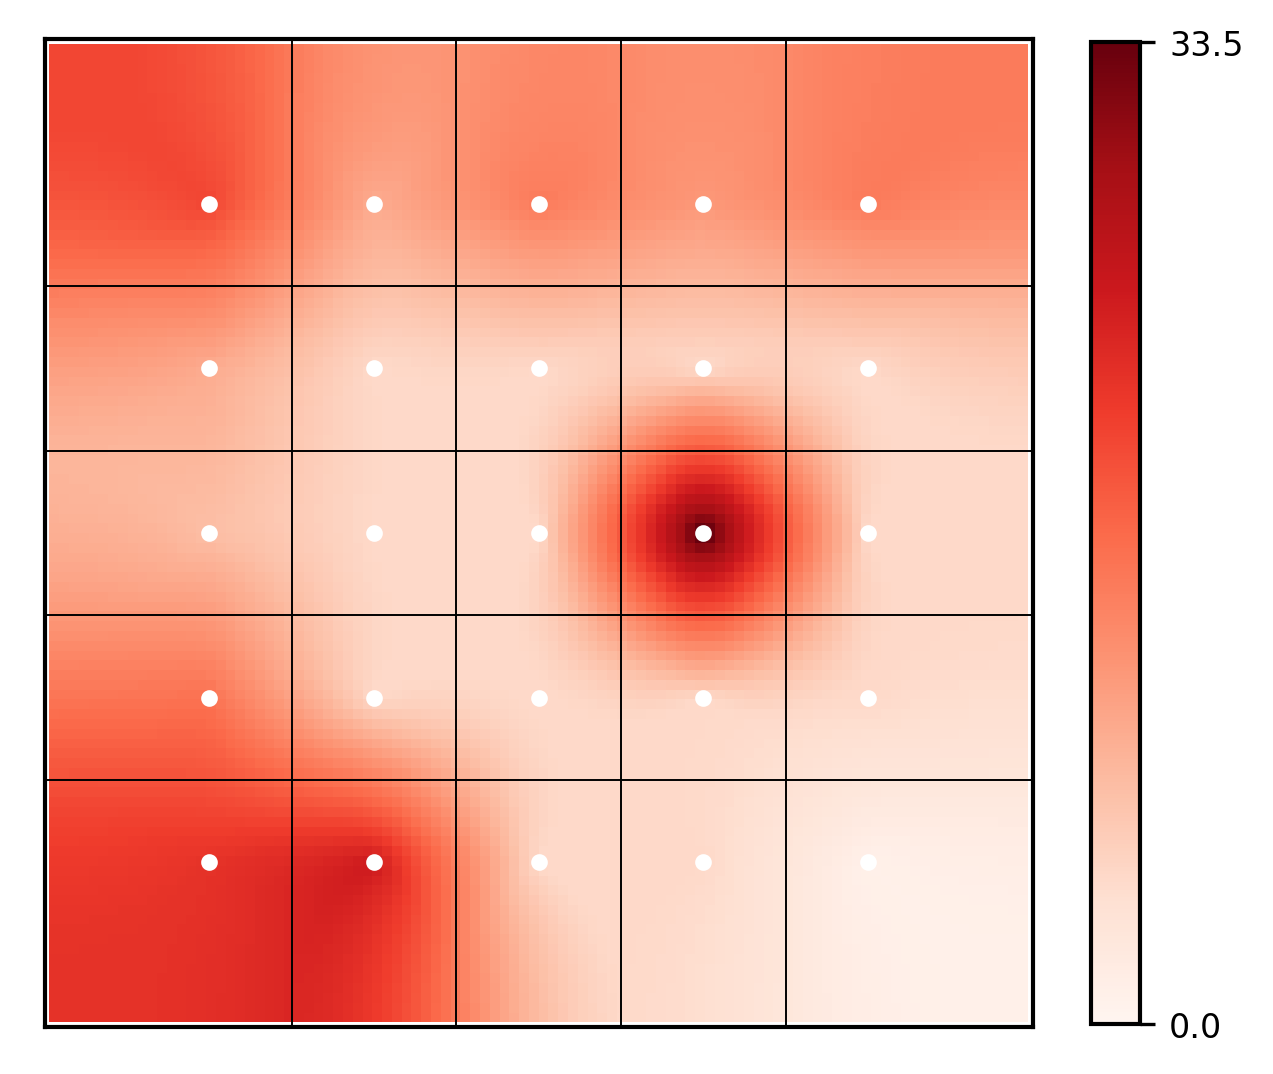

In [19]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
_, _, norm = drawInterpolation(tensor_fullresolution, samples, ax=ax, cmap=cm.get_cmap('Reds'), shrink=0.85)
drawVoronoiCells(tensor_fullresolution, ax=ax)
drawSampleLabels(tensor_fullresolution, ax=ax, color='w', marker='o', markersize=3, include_sample_labels=False, include_sample_indices=False)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

plt.savefig('diagrams/fullresolution.png')
_ = plt.show()

INFO:sensor_placement:Applied tensor in 0.00s


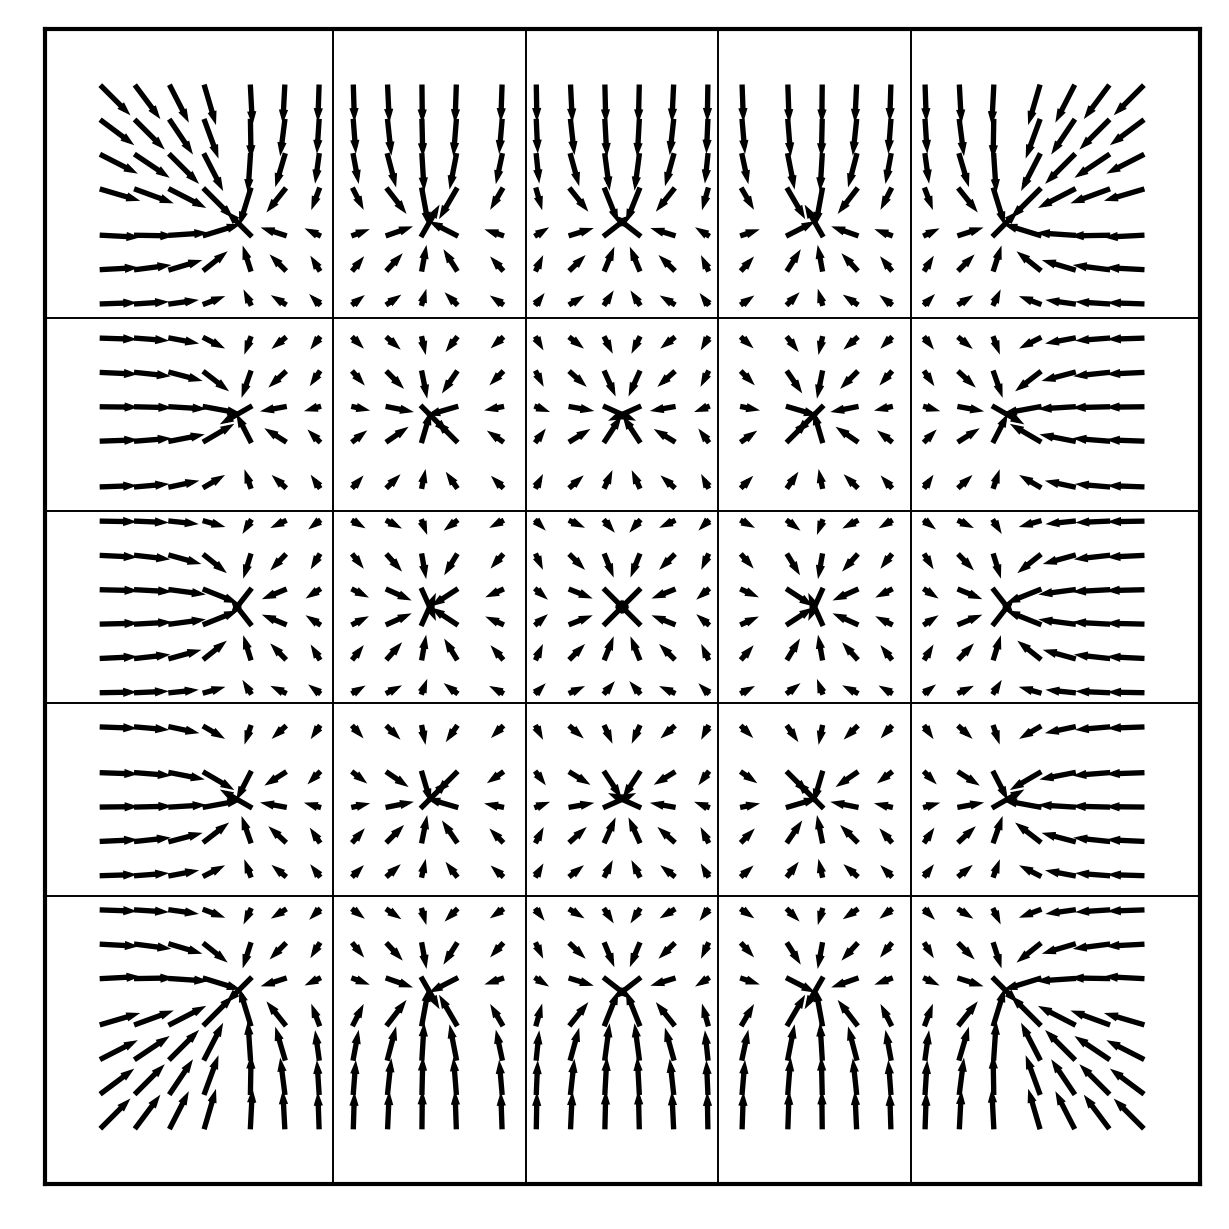

In [21]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

drawInterpolation(tensor_fullresolution, samples, ax=ax, include_interpolation=False)
for x in numpy.linspace(0.05, 0.95, 30):
    for y in numpy.linspace(0.05, 0.95, 30):
        drawResolvedVector(tensor_fullresolution, nearestPointTo(Point(x, y), tensor_fullresolution),
                           ax=ax, color='k', radius=0.025)
drawVoronoiCells(tensor_fullresolution, ax=ax)
drawSampleLabels(tensor_fullresolution, ax=ax, color='k', include_sample_labels=False, include_sample_indices=False)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

plt.savefig('diagrams/fullresolution-vectors.png')
_ = plt.show()

## Degraded sample

In [22]:
if exists('datasets/tensor_60.nc'):
    tensor_60 = NNNI.load('datasets/tensor_60.nc')
    retain_60 = list(tensor_60._samples.index)
    samples_60 = samples[retain_60]    
else:
    raise Exception('Can\'t load tensor')

INFO:sensor_placement:Instanciating tensor as NNNI
INFO:sensor_placement:Tensor limited to 1 core
INFO:sensor_placement:Computing Voronoi diagram
INFO:sensor_placement:Created Voronoi diagram in 0.00s
INFO:sensor_placement:Loaded tensor from datasets/tensor_60.nc in 0.00s


INFO:sensor_placement:Applied tensor in 0.00s


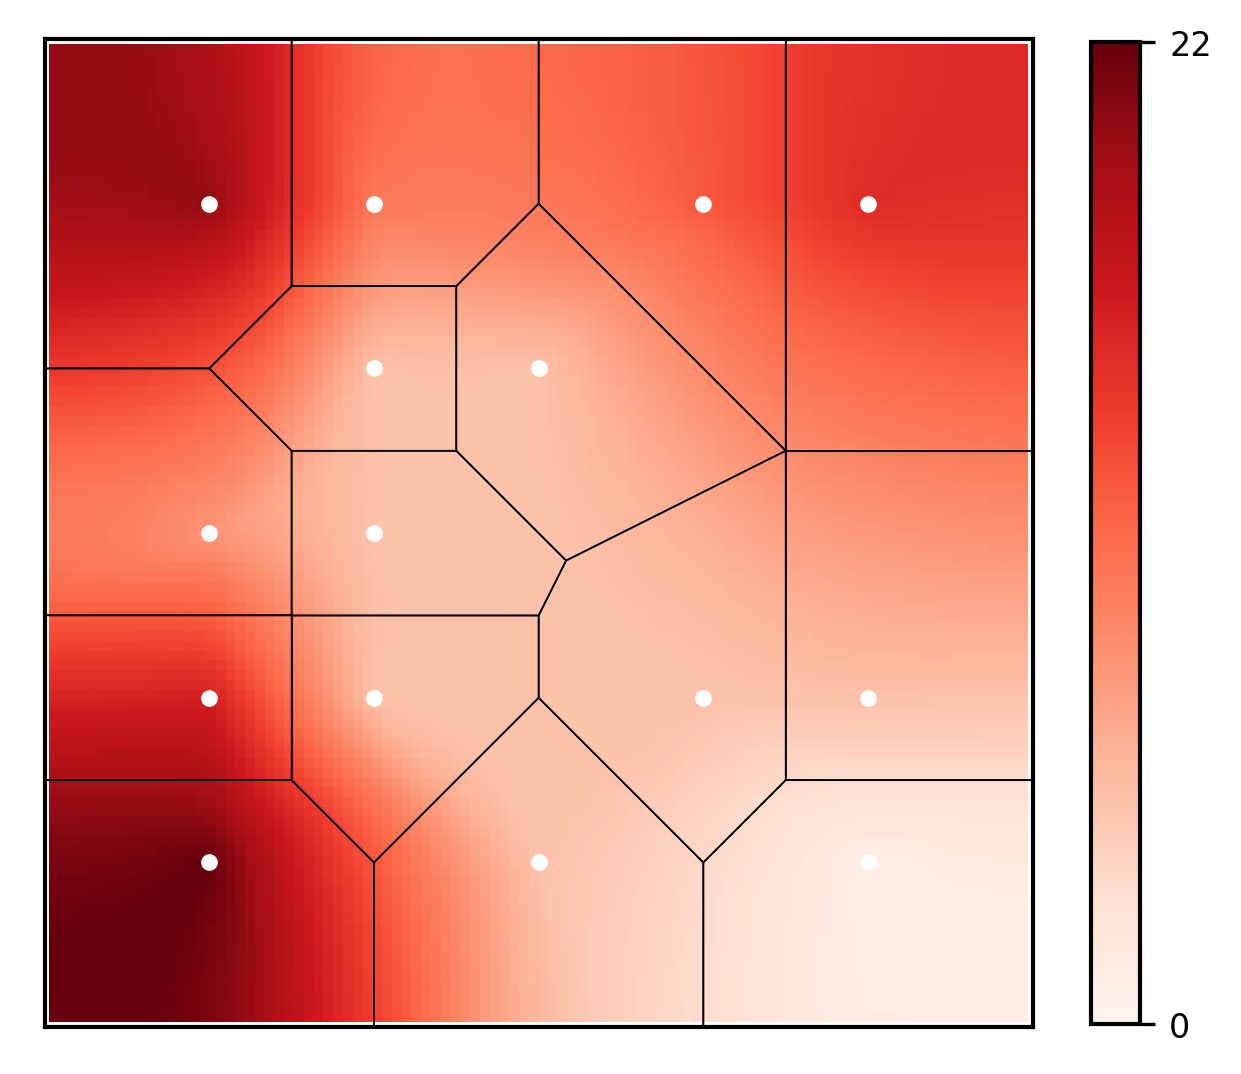

In [24]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
_, _, norm = drawInterpolation(tensor_60, samples_60, ax=ax, cmap=cm.get_cmap('Reds'), shrink=0.85)
drawVoronoiCells(tensor_60, ax=ax)
drawSampleLabels(tensor_60, ax=ax, color='w', marker='o', markersize=3, include_sample_labels=False, include_sample_indices=False)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

plt.savefig('diagrams/degraded60.png')
_ = plt.show()

INFO:sensor_placement:Applied tensor in 0.00s


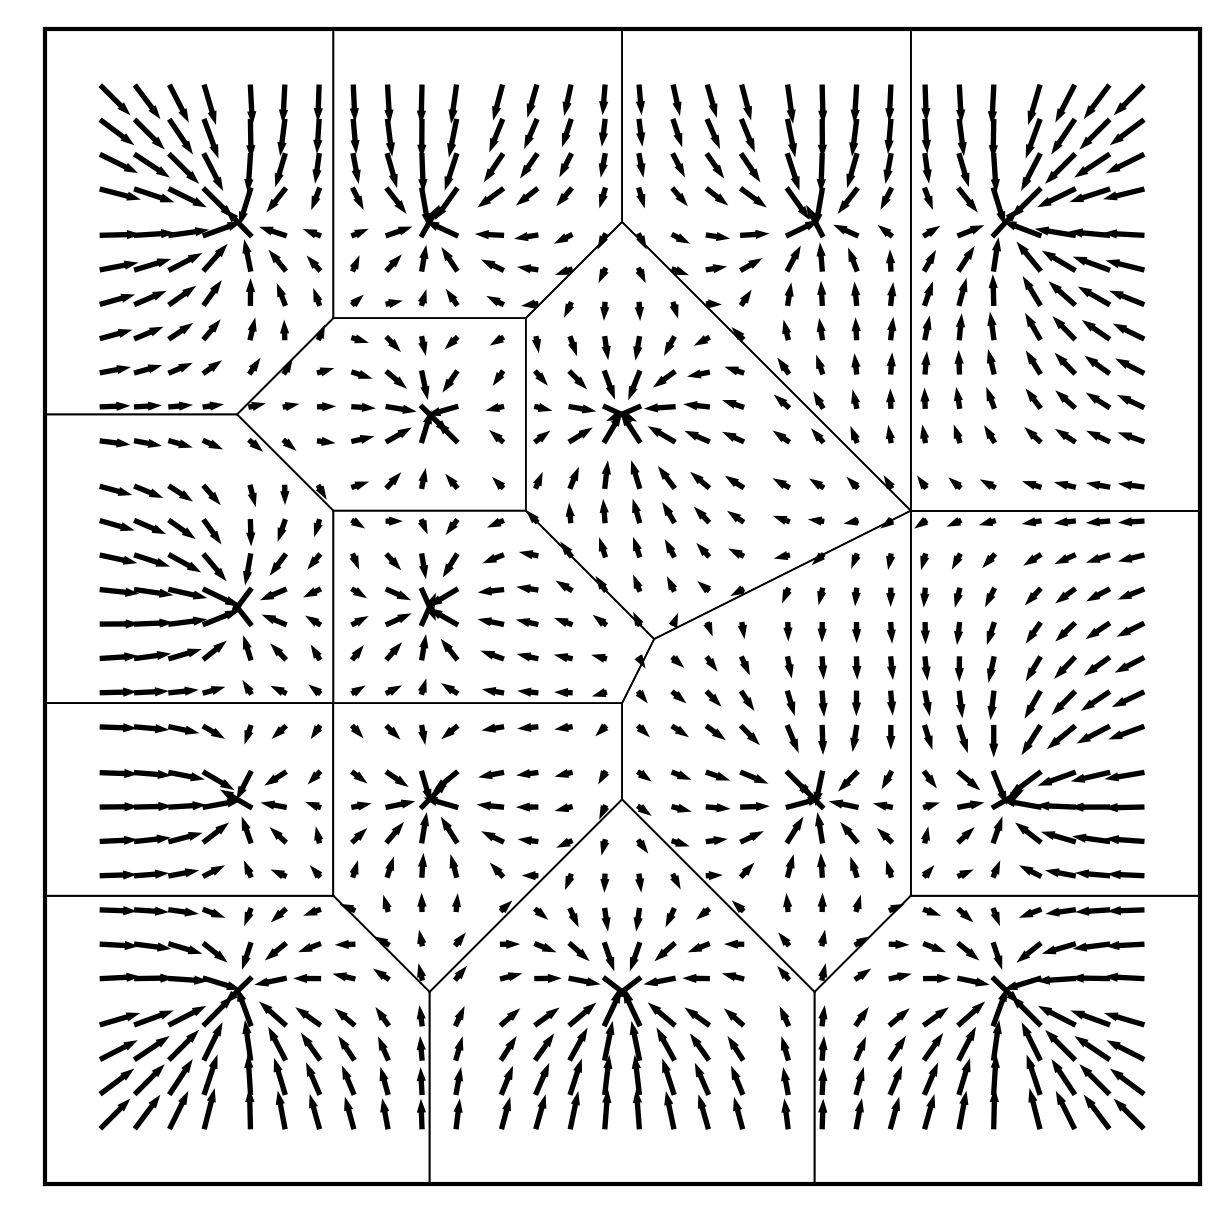

In [25]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

drawInterpolation(tensor_60, samples_60, ax=ax, include_interpolation=False)
for x in numpy.linspace(0.05, 0.95, 30):
    for y in numpy.linspace(0.05, 0.95, 30):
        drawResolvedVector(tensor_60, nearestPointTo(Point(x, y), tensor_60),
                           ax=ax, color='k', radius=0.025)
drawVoronoiCells(tensor_60, ax=ax)
drawSampleLabels(tensor_60, ax=ax, color='k', include_sample_labels=False, include_sample_indices=False)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

plt.savefig('diagrams/degraded60-vectors.png')
_ = plt.show()

## Assessing the effects of degradation

In [26]:
g_diff = tensor_fullresolution.apply(samples) - tensor_60.apply(samples_60)

INFO:sensor_placement:Applied tensor in 0.00s
INFO:sensor_placement:Applied tensor in 0.00s


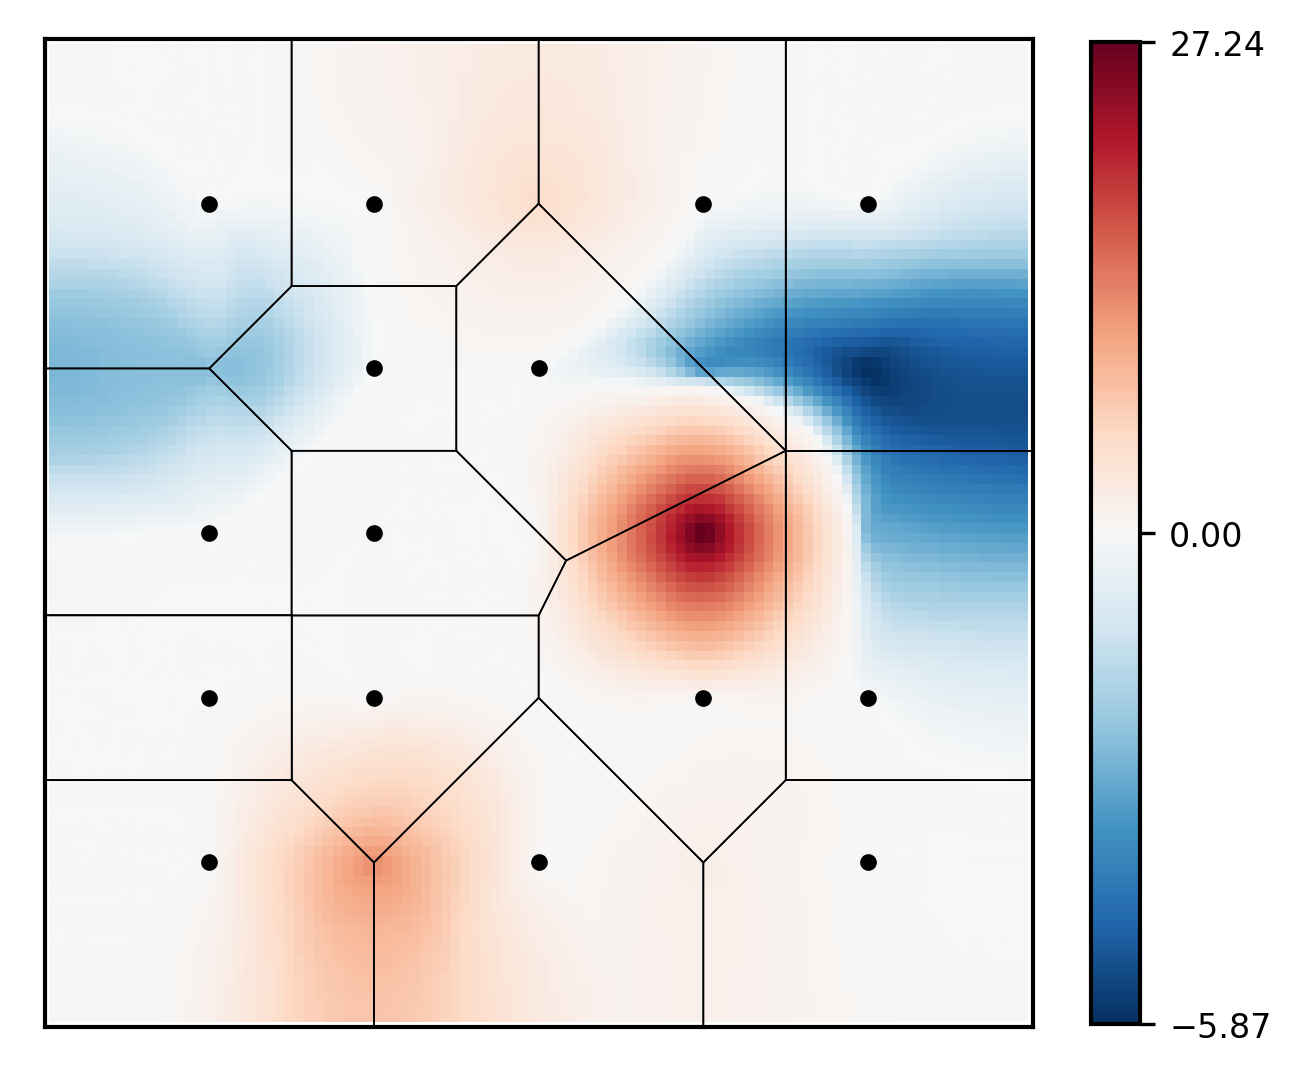

In [27]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
norm_diff = TwoSlopeNorm(vcenter=0, vmin=g_diff.min(), vmax=g_diff.max())
_, cax, _ = drawGrid(g_diff, xs, ys, ax=ax, norm=norm_diff, cmap=cm.get_cmap('RdBu_r'), shrink=0.85)
drawVoronoiCells(tensor_60, ax=ax)
drawSampleLabels(tensor_60, ax=ax, marker='o', markersize=3, include_sample_labels=False, include_sample_indices=False)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

plt.savefig('diagrams/fullresolution-degraded60.png')
_ = plt.show()

In [28]:
def contribution(tensor, s):
    si = tensor._voronoi.index.get_loc(s)
    tensor_si = tensor._tensor[:, :, si]
    return numpy.sum(tensor_si)

In [29]:
contributions = []
for s, _ in tensor_60._samples.iterrows():
    contributions.append(contribution(tensor_60, s))
tensor_60._samples['contribution'] = contributions

In [30]:
contribution_60_max = tensor_60._samples[tensor_60._samples['contribution'] == tensor_60._samples['contribution'].max()]
contribution_60_max_sample = contribution_60_max.index[0]
contribution_60_max_point = tensor_60._samples.loc[contribution_60_max_sample].geometry

In [31]:
tensor_59 = deepcopy(tensor_60)
tensor_59.removeSample(contribution_60_max_sample)

In [32]:
contribution_60_max_index = tensor_60._samples.index.get_loc(contribution_60_max_sample)
samples_59 = numpy.delete(samples_60, contribution_60_max_index)
pt = contribution_60_max_point.coords[0]

INFO:sensor_placement:Applied tensor in 0.00s


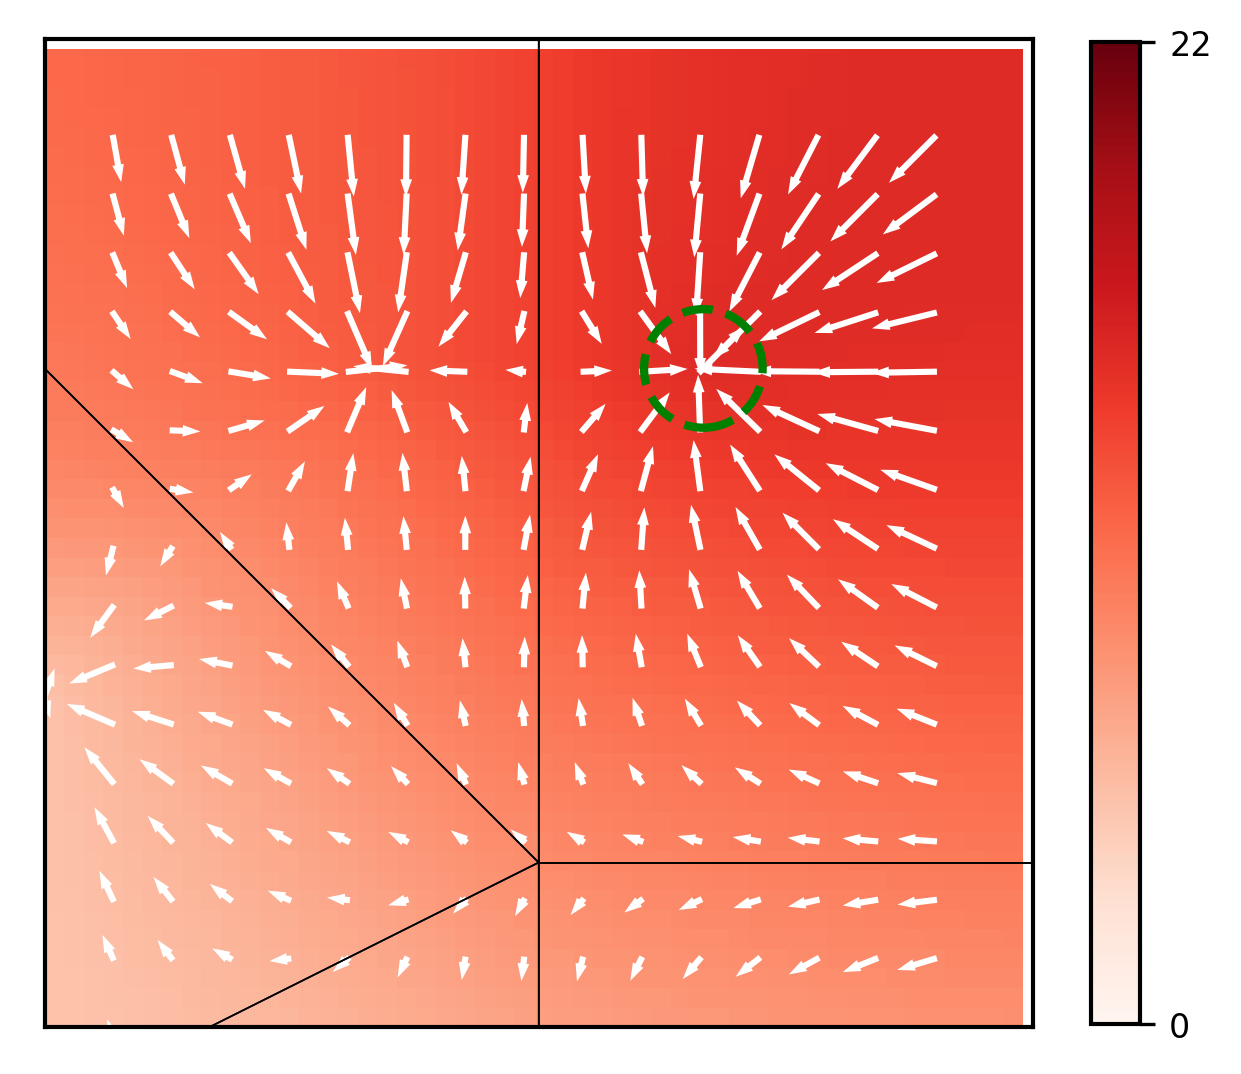

In [33]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
drawInterpolation(tensor_60, samples_60, ax=ax, norm=norm, cmap=cm.get_cmap('Reds'), shrink=0.85)
for x in numpy.linspace(0.5, 0.95, 16):
    for y in numpy.linspace(0.5, 0.95, 16):
        drawResolvedVector(tensor_60, nearestPointTo(Point(x, y), tensor_60),
                           ax=ax, color='w', radius=0.025)
drawVoronoiCells(tensor_60, ax=ax)
c = Circle(pt, radius=0.03,
           linestyle='--', linewidth=2, fill=False, color='g')
ax.add_artist(c)
ax.set_xlim([0.5, 1.0])
ax.set_ylim([0.5, 1.0])

plt.savefig('diagrams/degraded60-detail.png')
_ = plt.show()

INFO:sensor_placement:Applied tensor in 0.00s


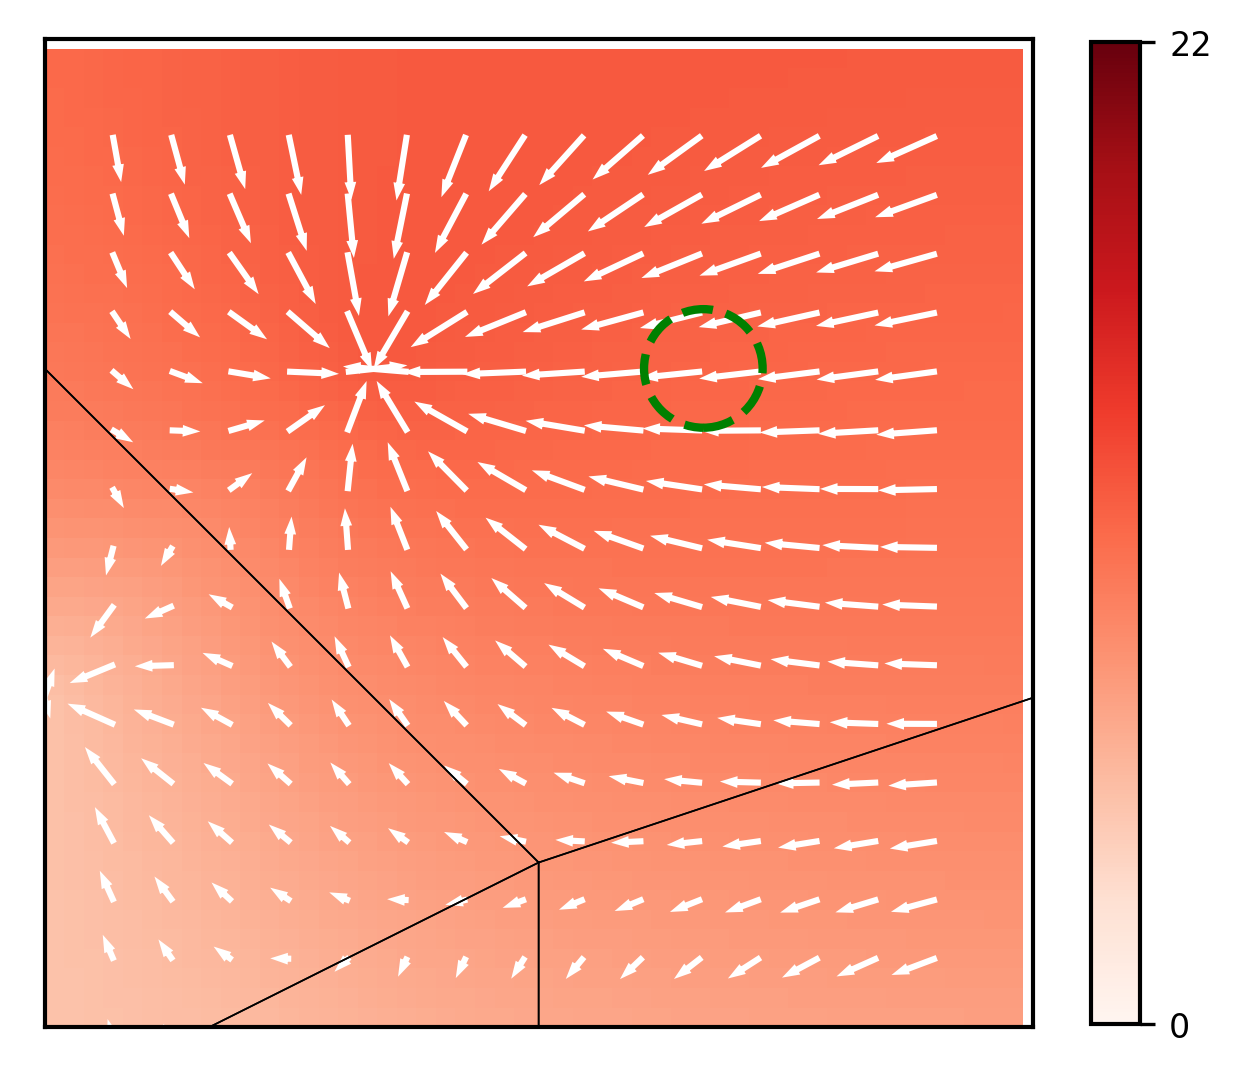

In [35]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
drawInterpolation(tensor_59, samples_59, ax=ax, norm=norm, cmap=cm.get_cmap('Reds'), shrink=0.85)
for x in numpy.linspace(0.5, 0.95, 16):
    for y in numpy.linspace(0.5, 0.95, 16):
        drawResolvedVector(tensor_59, nearestPointTo(Point(x, y), tensor_59),
                           ax=ax, color='w', radius=0.025)
drawVoronoiCells(tensor_59, ax=ax)
c = Circle(pt, radius=0.03,
           linestyle='--', linewidth=2, fill=False, color='g')
ax.add_artist(c)
ax.set_xlim([0.5, 1.0])
ax.set_ylim([0.5, 1.0])

plt.savefig('diagrams/degraded59-detail.png')
_ = plt.show()

In [36]:
def cosineDistance(v, w):
    d = numpy.dot(v, w)
    mag_v = numpy.sqrt(numpy.dot(v, v))
    mag_w = numpy.sqrt(numpy.dot(w, w))
    return 1 - d / (mag_v * mag_w)

In [53]:
def computeTurn(tensor1, tensor2):
    '''Compute the turning field between two tensors.'''

    # sanity check
    if tensor1._tensor.shape != tensor2._tensor.shape:
        raise ValueError('Tensors are not the same shape.')
        
    # extract grid
    xs, ys = tensor1._xs, tensor1._ys
    
    # construct the turning grid
    ts = numpy.zeros((len(xs), len(ys)))
    for i in range(len(xs)):
        for j in range(len(ys)):
            v = tensor1._tensor[i, j, :]
            w = tensor2._tensor[i, j, :]
            
            # compute the angle
            ts[i, j] = cosineDistance(v, w)
            
    # return the turning field
    return ts

def computeTurnOnRemoval(tensor, s):
    '''Compute the turning field caused by the removal of the given sample.'''

    # extract grid
    xs, ys = tensor._xs, tensor._ys
    
    # record the index of the sample to be removed
    si = tensor._samples.index.get_loc(s)
    
    # construct the tensor induced by removing s
    reduced = deepcopy(tensor)
    reduced.removeSample(s)
    
    # construct the turning grid
    ts = numpy.zeros((len(xs), len(ys)))
    for i in range(len(xs)):
        for j in range(len(ys)):
            v = tensor._tensor[i, j, :]
            w = reduced._tensor[i, j, :]
            
            # extend the reduced vector with a zero at the correct index
            w1 = numpy.append(w, numpy.zeros((1)))
            w1[si + 1:] = w1[si:-1]
            w1[si] = 0.0
            
            # compute the angle
            ts[i, j] = cosineDistance(v, w1)
            
    # return the turning field and the reduced tensor
    return ts, reduced

def drawTurn(ts,
             ax=None, cmap=None, norm=None, fontsize=None, ticks=None, format=None, shrink=1.0,
             include_colorbar=True):
    '''Draw the turning of the vector field.'''

    # fill in defaults
    if ax is None:
        ax = plt.gca()
    if cmap is None:
        cmap = cm.get_cmap('viridis')
    
    # construct a mesh
    xx, yy = numpy.meshgrid(xs, ys)

    # create the colours on the mesh
    if norm is None:
        norm = Normalize(vmin=ts.min(), vmax=ts.max())
    mp = ax.pcolormesh(xx, yy, ts.T, cmap=cmap, norm=norm)
    ax.set_aspect(1.0)

    # add colorbar
    if include_colorbar:
        cbar = plt.colorbar(mappable=mp,
                            ax=ax, cmap=cmap, norm=norm, format=format,
                            fraction=0.1, shrink=shrink)

        if ticks is not None:
            cbar.set_ticks(ticks)
        else:
            # ticks at the extrema, and at 0 if there's a change of sign
            if norm.vmin * norm.vmax < 0:
                cbar.set_ticks([norm.vmin, 0.0, norm.vmax])
            else:
                cbar.set_ticks([norm.vmin, norm.vmax])
    else:
        cbar = None

    # return the main axes, the colorbar, and the norm used,
    return ax, cbar, norm

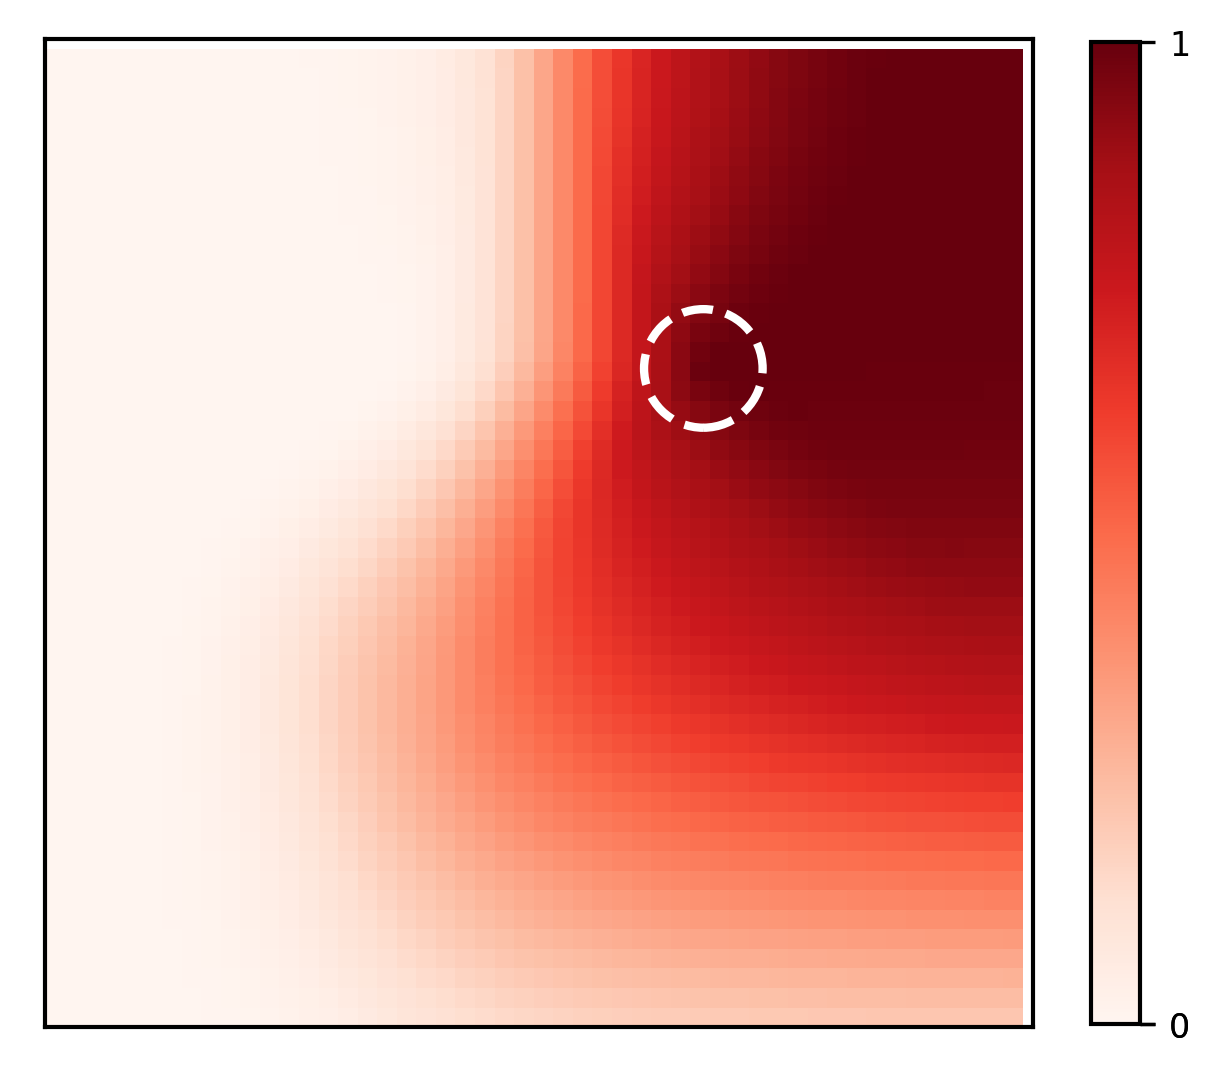

In [46]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
ts, _ = computeTurnOnRemoval(tensor_60, contribution_60_max_sample)
drawTurn(ts, ax=ax, cmap=cm.get_cmap('Reds'), shrink=0.85)
c = Circle(pt, radius=0.03,
           linestyle='--', linewidth=2, fill=False, color='w')
ax.add_artist(c)
ax.set_xlim([0.5, 1.0])
ax.set_ylim([0.5, 1.0])

plt.savefig('diagrams/degraded59-turn.png')
_ = plt.show()

## Error correction

In [47]:
percentageError = 1
errorAtSample = 6

errorAt_index = tensor_60._samples.index.get_loc(errorAtSample)
samples_60_error = deepcopy(samples_60)
samples_60_error[errorAt_index] *= (1 + (percentageError / 100))

errorAt_pt = tensor_60._samples.loc[errorAtSample].geometry.coords[0]

In [48]:
g_error = tensor_60.apply(samples_60) - tensor_60.apply(samples_60_error)

INFO:sensor_placement:Applied tensor in 0.00s
INFO:sensor_placement:Applied tensor in 0.00s


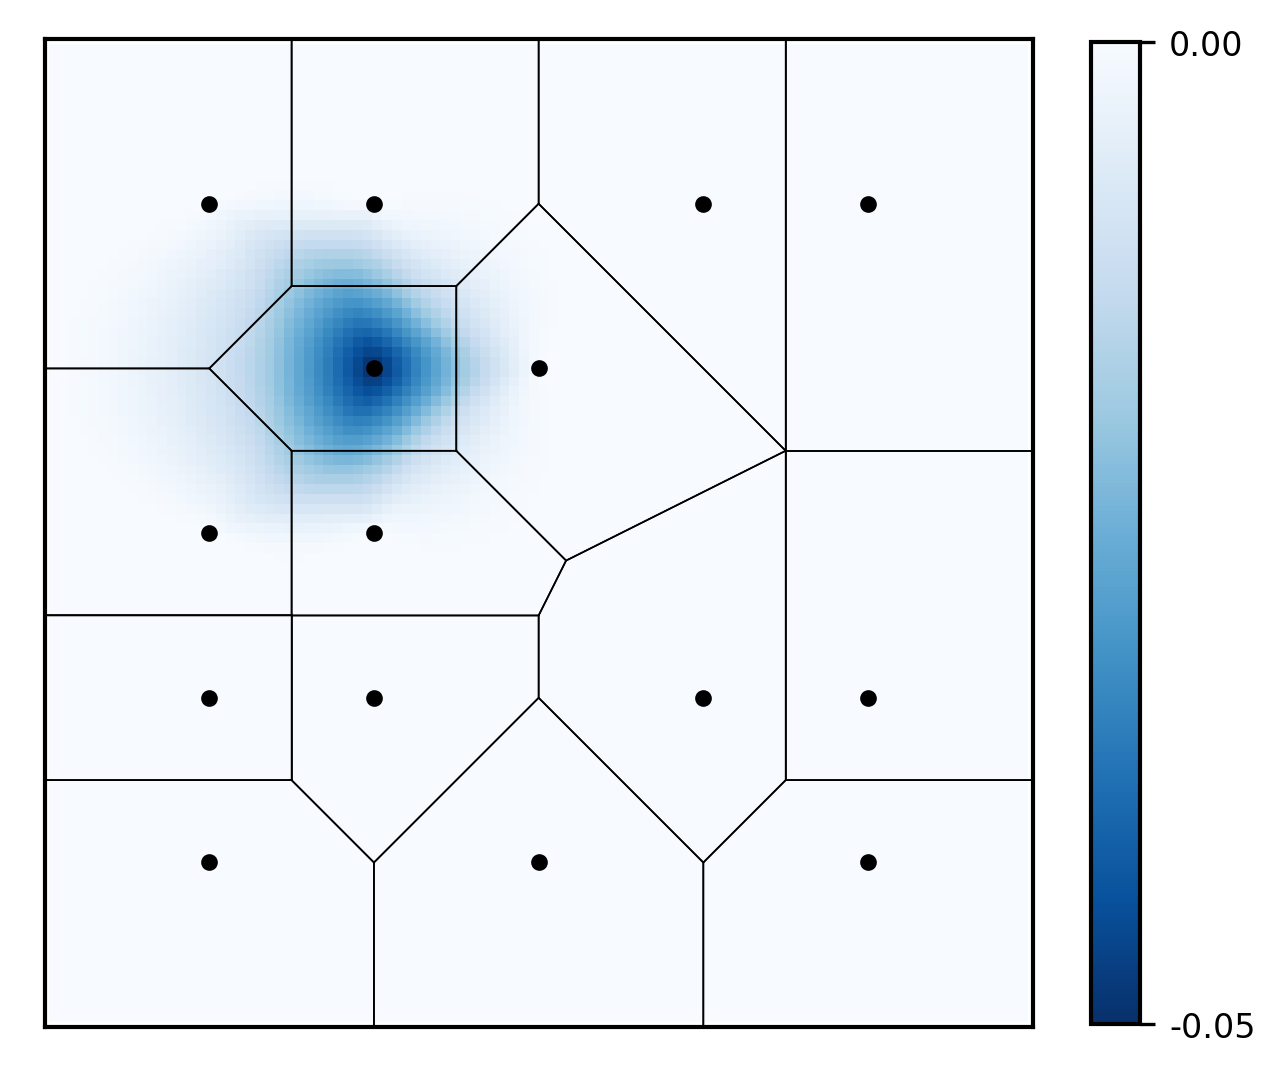

In [57]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
norm_diff = Normalize(vmin=g_error.min(), vmax=g_error.max())
_, cax, _ = drawGrid(g_error, xs, ys, ax=ax, norm=norm_diff, cmap=cm.get_cmap('Blues_r'), format=StrMethodFormatter('{x:.2f}'), shrink=0.85)
drawVoronoiCells(tensor_60, ax=ax)
drawSampleLabels(tensor_60, ax=ax, marker='o', markersize=3, include_sample_labels=False, include_sample_indices=False)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

plt.savefig('diagrams/degraded60-error-value.png')
_ = plt.show()

In [50]:
tensor_60_corr = deepcopy(tensor_60)
t = tensor_60_corr._tensor
for i in range(len(xs)):
    for j in range(len(ys)):
        w = t[i, j, errorAt_index]
        if w > 0:
            wp = w / (1 + (percentageError / 100))
            t[i, j, errorAt_index] = wp

In [51]:
g_corr = tensor_60.apply(samples_60_error) - tensor_60_corr.apply(samples_60_error)

INFO:sensor_placement:Applied tensor in 0.00s
INFO:sensor_placement:Applied tensor in 0.00s


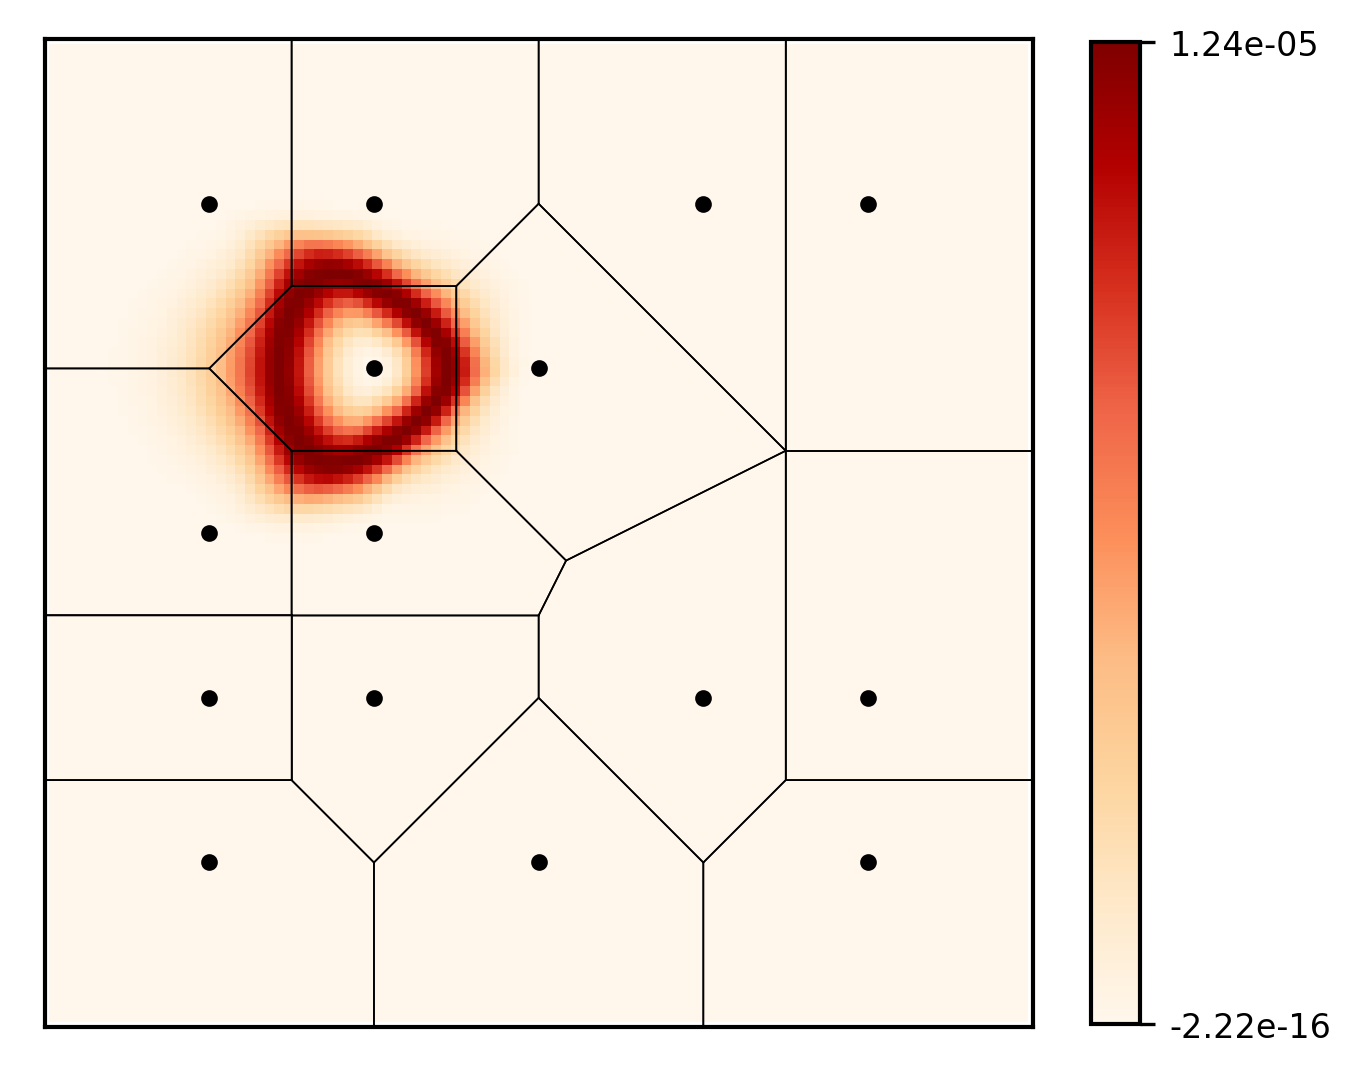

In [58]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
ts = computeTurn(tensor_60, tensor_60_corr)
drawTurn(ts, ax=ax, cmap=cm.get_cmap('OrRd'), ticks=[ts.min(), ts.max()], format=StrMethodFormatter('{x:.2e}'), shrink=0.85)
drawVoronoiCells(tensor_60, ax=ax)
drawSampleLabels(tensor_60, ax=ax, marker='o', markersize=3, include_sample_labels=False, include_sample_indices=False)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

plt.savefig('diagrams/degraded60-error-turn.png')
__ = plt.show()